# 가장 좋은 결과를 낼 수 있는 feature항목 추출

## 모든 feature를 사용한 결과와, 선택 추출된 feature만 사용한 결과 정확도에 차이가 남
#### ligistic 회귀 이용하여 coef_ 항목에서 영향력이 높은 feature를 선택. 최적의 갯수 선택

### 데이터 준비하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# 로지스틱회귀후에 .coef_ 항목에서 기준(criteria, 계수)보다 높은 영향력을 미치는 feature column 선택
def select_features(df, coef, criteria):
    sel_num = np.where(np.abs(coef) > criteria )[1]
    sel_col = df.columns[sel_num]
    return sel_col

In [3]:
def get_scores(data, target):
    train_input, test_input, train_target, test_target = train_test_split(data, target, random_state=42, test_size=0.2, stratify=target)

    ss = StandardScaler()
    ss.fit(train_input)
    train_scaled = ss.transform(train_input)
    test_scaled = ss.transform(test_input)

    lr = LogisticRegression(C=20, max_iter=4000) # max_iter default 100, 
#     lr = LogisticRegression(solver='lbfgs', max_iter=1000) # max_iter default 100, 
    lr.fit(train_scaled, train_target)

    train_score = lr.score(train_scaled, train_target)
    test_score = lr.score(test_scaled, test_target)
#     print(f'train score: {train_score:.4f} \n test score; {test_score:.4f}')
    return train_score, test_score, lr.coef_, lr.intercept_

In [4]:
def find_best_result(data, target):
# min을 하나씩 제거하면서 최고의 결과를 가져오는 feature갯수(항목) 선택

    train_score_list= []
    test_score_list = []
#     data_columns = []
#     data_coef = []
    test_s = 0
    train_score, test_score, coef, intercept = get_scores(data, target)
    for _ in range(len(data.columns)-1):
        criteria = np.abs(coef).min()
        sel_col = select_features(data, coef, criteria)
        data = df[sel_col]
        train_score, test_score, coef, intercept = get_scores(data, target)

        if test_score > test_s:
            test_s = test_score
            data_columns = sel_col
            data_coef = coef

        train_score_list.append(train_score)
        test_score_list.append(test_score)
    
    return train_score_list, test_score_list, data_columns, data_coef

In [5]:
# 분석용 데이터 입력
directory_for_ml = '../data/data_for_ml/'
fname = 'df_hyunmotor_sel.pkl'
f_name = directory_for_ml + fname
df = pd.read_pickle(f_name)

In [6]:
data = df.iloc[:, :-2]
target = df.iloc[:, -1]

In [7]:
train_score_list, test_score_list, data_columns, data_coef = find_best_result(data, target)

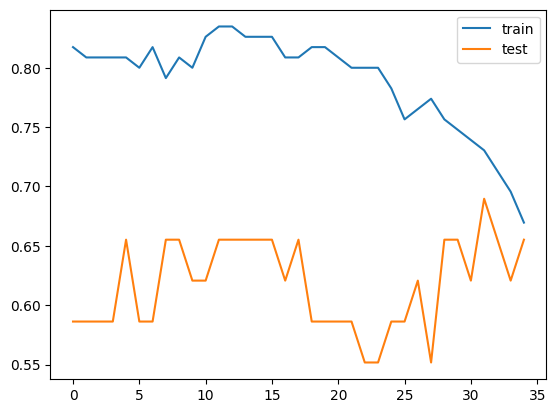

In [8]:
plt.plot(train_score_list, label = 'train')
plt.plot(test_score_list, label = 'test')
plt.legend()

In [9]:
print(data_columns, data_coef)
print("train_max: {:.4f}, test_max: {:.4f}".format(max(train_score_list), max(test_score_list)))

Index(['retail', 'ixic_f_cr', 'kosdaq_cr', 'sox_cr'], dtype='object') [[ 0.97192461 -0.65427905  1.06967976  0.50891585]]
train_max: 0.8348, test_max: 0.6897


In [10]:
data_columns.shape

(4,)

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate, train_test_split
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [12]:
data_new = data[data_columns]
target = df.iloc[:, -1]

In [13]:
data_new.tail()

,retail,ixic_f_cr,kosdaq_cr,sox_cr
2023-02-10,-0.358131,-0.64,-1.55,-1.58
2023-02-13,-0.147583,1.57,0.01,1.53
2023-02-17,-420.715481,-0.74,-1.16,-1.62
2023-02-21,-1.041371,-2.28,0.57,-3.31
2023-02-22,-0.789130,0.01,-1.88,-0.48


In [14]:
train_input, test_input, train_target, test_target = train_test_split(data_new, target, random_state=42, test_size=0.2, stratify=target)

In [15]:
print(train_input.shape, train_target.shape)

(115, 4) (115,)


In [16]:
np.unique(train_target, return_counts=True)

(array([0, 1], dtype=int64), array([62, 53], dtype=int64))

In [17]:
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [18]:
value = []
for iter in range(5, 50, 1):
    sc = SGDClassifier(loss='log', max_iter=iter, random_state=42)
#     sc = SGDClassifier(max_iter=iter, random_state=42)
    scores = cross_validate(sc,
                            X=train_scaled, y=train_target,
                            n_jobs=-1)
#     print(scores['test_score'].mean())
    value.append(scores['test_score'].mean())

In [19]:
print("max", max(value))

max 0.6695652173913043


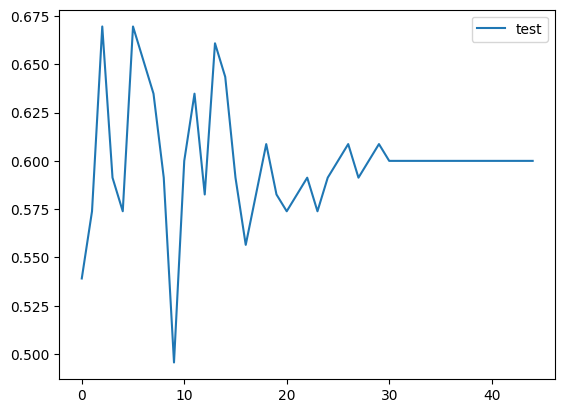

In [20]:
plt.plot(value, label = 'test')
plt.legend()

### 인공신경망

In [21]:
def model_fn(num_element, inp_num, num_out, a_layer=None):
    model = Sequential()
    model.add(Dense(num_element, activation='sigmoid', input_shape=(inp_num,)))
    if a_layer:
        model.add(a_layer)
    model.add(Dense(num_out, activation='sigmoid'))
    
    return model

In [22]:
# model = model_fn(10, len(data_new.columns), 2, Dropout(0.3))
model = model_fn(10, len(data_new.columns), 2)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 72
Trainable params: 72
Non-trainable params: 0
_________________________________________________________________


In [23]:
checkpoint_cb = ModelCheckpoint('best_model.h5', save_best_only=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [24]:
history = model.fit(train_scaled, train_target, epochs=2000, verbose=0,
                    callbacks=[checkpoint_cb, earlystopping_cb],
                    validation_data=(test_scaled, test_target))

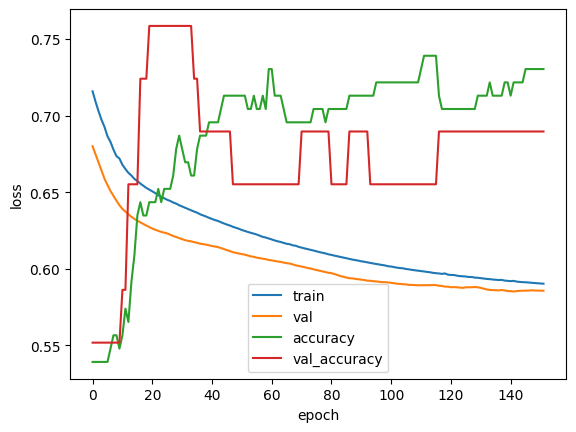

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val', 'accuracy', 'val_accuracy'])
plt.show()

In [26]:
earlystopping_cb.stopped_epoch

151

In [27]:
model.evaluate(test_scaled, test_target)

1/1 [==============================] - 0s 16ms/step - loss: 0.5851 - accuracy: 0.6897


[0.5851262807846069, 0.6896551847457886]

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])